In [3]:
#!pip install scikit-learn==0.21.3

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import itertools

from sklearn.metrics import roc_auc_score, r2_score, accuracy_score

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
import sklearn
sklearn.__version__

'0.21.3'

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [7]:
#data=pd.read_csv("../data/raw/databinarystudents.csv")

datatr=pd.read_csv("databinarystudents_train.csv")
datats=pd.read_csv("databinarystudents_test.csv")
data=pd.concat([datatr,datats])
data.reset_index(inplace = True)
data = data.drop(['index'], axis = 1)
data.head()

,id,yL,x1,x2,x3,x4,x5,x6,x7,x8,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
0,1.0,1.0,49.856,118.8,1.0,0.0,0.0,0.0,0.0,16.32096,...,0.9709,0.0003,6.0,6.0,24.7138,0.0,0.0,7.0,0.056546,0.112860
1,2.0,1.0,71.836,34.8,0.0,0.0,0.0,0.0,1.0,15.00535,...,0.4200,0.0000,8.0,4.0,38.0658,0.0,0.0,7.0,0.655260,0.886908
2,3.0,1.0,66.725,41.8,0.0,1.0,0.0,0.0,0.0,17.07023,...,0.9650,0.0000,6.0,6.0,48.3807,0.0,1.0,4.0,0.067855,0.133944
3,4.0,0.0,41.696,132.0,0.0,0.0,1.0,0.0,0.0,16.31460,...,0.0091,0.0001,6.0,4.0,59.8410,0.0,0.0,7.0,0.133230,0.260102
4,5.0,1.0,71.351,24.2,1.0,0.0,0.0,0.0,0.0,11.10790,...,0.0051,0.0000,5.0,7.0,175.9250,0.0,0.0,3.0,0.318584,0.627729


## Selección de características

In [8]:
sel_fea = []
coefi = []

for j in range(1,101):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['yL'], axis=1)
    Y_train=train['yL']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['yL'], axis=1)
    Y_test=test['yL']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    model_all_features = LogisticRegression(C=1, penalty='elasticnet', solver='saga',l1_ratio=0.5, max_iter=10000, random_state=0)
    model_all_features.fit(X_train, Y_train)
    y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
    auc_score_all = roc_auc_score(Y_test, y_pred_test)
    
    features = pd.Series(abs(model_all_features.coef_[0,:])) # esto con valor absoluto?
    features.index = X_train.columns
    features.sort_values(ascending=False, inplace=True)
    
    features = list(features.index)
    
    # Modelo con la característca más importante (desde la que se inicia la adición)
    model_one_feature = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                        l1_ratio=0.5, max_iter=10000, random_state=0)
    model_one_feature.fit(X_train[features[0]].to_frame(), Y_train)
    
    y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]
    auc_score_first = roc_auc_score(Y_test, y_pred_test)
    
    # Adición de características y evaluación de modelos, una a la vez (en orden de importancia)
    
    tol = 0.001
    features_to_keep = [features[0]]
    count = 1
    for feature in features[1:]:
        count = count + 1
        model_int = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                        l1_ratio=0.5, max_iter=10000, random_state=0)
        model_int.fit(X_train[features_to_keep + [feature] ], Y_train)
        
        y_pred_test = model_int.predict_proba(X_test[features_to_keep + [feature] ])[:, 1]
        auc_score_int = roc_auc_score(Y_test, y_pred_test)
        diff_auc = auc_score_int - auc_score_first
        
        if diff_auc >= tol:
            auc_score_first = auc_score_int
            features_to_keep.append(feature)
        #else:
            #print()
     
    # Modelo con características seleccionadas
    final_m = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=10000, random_state=0)
    final_m.fit(X_train[features_to_keep], Y_train)
    
    y_pred_test = final_m.predict_proba(X_test[features_to_keep])[:,1]
    
    ROC_AUC_final = roc_auc_score(Y_test, y_pred_test)
    y_pred_test1 = final_m.predict(X_test[features_to_keep])
    acc = accuracy_score(Y_test, y_pred_test1)
    
    finalcoe = final_m.coef_.tolist()
    
    sel_fea.extend(features_to_keep)
    coefi.extend(finalcoe)

In [9]:
coefi = list(itertools.chain.from_iterable(coefi))

#### Coeficientes y características seleccionadas

In [10]:
summar = pd.concat([pd.DataFrame(sel_fea), pd.DataFrame(coefi)],axis=1)

In [11]:
summar.columns=['selected_feature','coefficient']

Ditribución de los coeficientes por característica

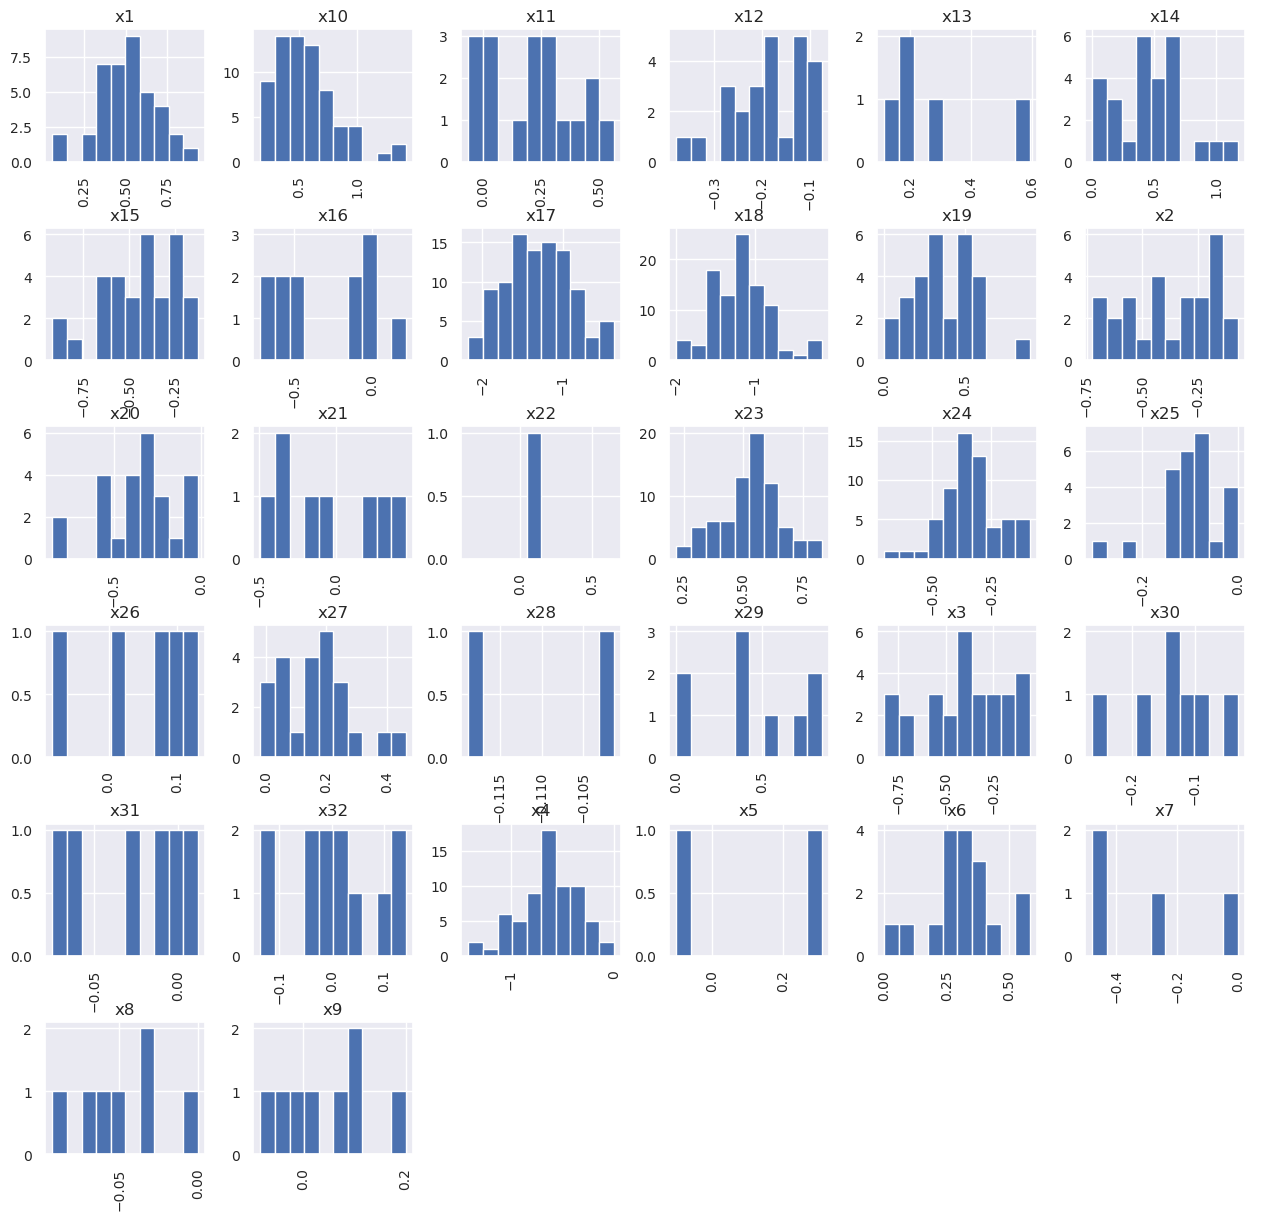

In [12]:
import seaborn.apionly as snsa
snsa.set()
summar.hist(by='selected_feature', column ='coefficient', xlabelsize=10, ylabelsize=10, figsize=(15,15))
plt.show()

Probabilidad de selección de cada variable

In [13]:
summar['selected_feature'].value_counts()

x17    98
x18    96
x23    75
x10    69
x4     68
x24    60
x1     39
x15    32
x3     29
x19    28
x2     28
x14    27
x25    25
x20    25
x12    25
x27    23
x11    18
x6     17
x16    12
x32    12
x29     9
x21     8
x9      8
x8      7
x30     7
x31     6
x26     5
x13     5
x7      4
x28     2
x5      2
x22     1
Name: selected_feature, dtype: int64

## Entrenamiento del modelo

In [14]:
roc = []
accur = []

for j in range(1+1000,101+1000):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['yL'], axis=1)
    Y_train=train['yL']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['yL'], axis=1)
    Y_test=test['yL']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    # Modelo con características seleccionadas
    
    final_m = LogisticRegression(C=1, penalty='elasticnet', solver='saga',
                                   l1_ratio=0.5, max_iter=10000, random_state=0)
    final_m.fit(X_train.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1), Y_train)
    
    y_pred_test = final_m.predict_proba(X_test.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1))[:,1]
    ROC_AUC_final = roc_auc_score(Y_test, y_pred_test)
    
    y_pred_test1 = final_m.predict(X_test.filter(['x17', 'x18', 'x23', 'x4', 'x10', 'x24'], axis=1))
    acc = accuracy_score(Y_test, y_pred_test1)
    
    roc.append(ROC_AUC_final)
    accur.append(acc)

#### AUC y Accuracy

In [15]:
summar1 = pd.concat([pd.DataFrame(roc), pd.DataFrame(accur)],axis=1)

In [16]:
summar1.columns=['ROC_AUC','Accuracy']

Distribución del AUC

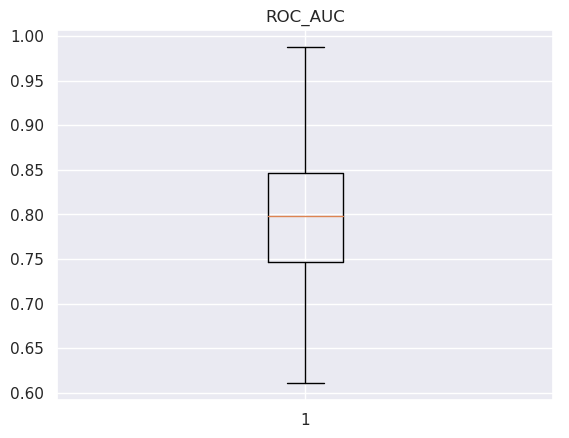

In [17]:
fig1, ax1 = plt.subplots()
ax1.set_title('ROC_AUC')
boxplot = ax1.boxplot(summar1['ROC_AUC'])

In [18]:
print('Q1:', np.percentile(summar1['ROC_AUC'],25))
print('Median:',np.median(summar1['ROC_AUC']))
print('Q3:', np.percentile(summar1['ROC_AUC'],75))

Q1: 0.7463165489481279
Median: 0.7979784909132734
Q3: 0.8466431229589124


Distribución accuracy

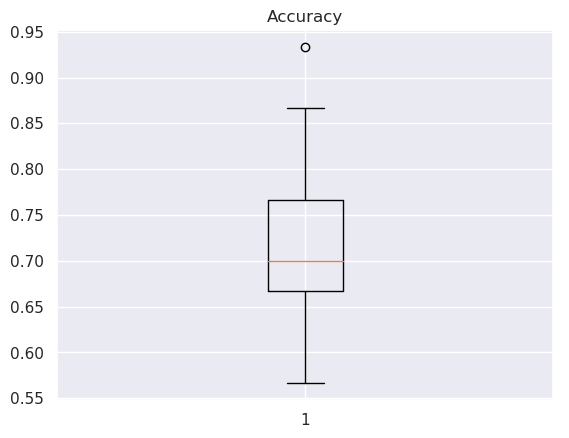

In [19]:
fig2, ax2 = plt.subplots()
ax2.set_title('Accuracy')
boxplot = ax2.boxplot(summar1['Accuracy'])

In [20]:
print('Q1:', np.percentile(summar1['Accuracy'],25))
print('Median:',np.median(summar1['Accuracy']))
print('Q3:', np.percentile(summar1['Accuracy'],75))

Q1: 0.6666666666666666
Median: 0.7
Q3: 0.7666666666666667
